In [1]:
%matplotlib inline
import pennylane as qml
import torch
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import display, clear_output

torch.manual_seed(42)
torch.set_num_threads(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.path.join(os.path.dirname(os.path.abspath("")))

torch.set_default_dtype(torch.float32)

# QNet Parameter
N_WIRES = 4
N_LAYERS = 5


# FNN Basis Net
HIDDEN_LAYER_FNN = 1
NEURONS_FNN = 20

# Domain Parameter
T_END = 1.0
T_COLOC_POINTS = 100
X_COLOC_POINTS = 100
INITIAL_VALUE_SCALING = 1e3

# Causality Parameter
USE_CAUSALITY = True
eps_array = [200]
sigma = 0.95

In [2]:

# Generate Collocation Points
t = torch.linspace(0.0, T_END, T_COLOC_POINTS)
x = torch.linspace(-1.0, 1.0, X_COLOC_POINTS)
input_domain = torch.tensor(list(product(t, x)), device=device)

domain_bounds = torch.tensor([[0.0, -1.0], [T_END, 1.0]], device=device)

init_val_mask = input_domain[:, 0] == 0.0
init_val_colloc = input_domain[init_val_mask]

periodic_boundary_top_mask = (input_domain[:, 1] == 1.0)
periodic_boundary_top_colloc = input_domain[periodic_boundary_top_mask & ~init_val_mask]

periodic_boundary_bottom_mask = (input_domain[:, 1] == -1.0)
periodic_boundary_bottom_colloc = input_domain[periodic_boundary_bottom_mask & ~init_val_mask]

# Combined Boundary Mask
boundary_mask = init_val_mask | periodic_boundary_top_mask | periodic_boundary_bottom_mask

# Filter out boundary points from domain_colloc
interior_colloc = input_domain[~boundary_mask]


input_domain = input_domain.clone().detach().requires_grad_(True).to(device)
init_val_colloc = init_val_colloc.clone().detach().requires_grad_(True).to(device)
periodic_boundary_top_colloc = periodic_boundary_top_colloc.clone().detach().requires_grad_(True).to(device)
periodic_boundary_bottom_colloc = periodic_boundary_bottom_colloc.clone().detach().requires_grad_(True).to(device)
interior_colloc = interior_colloc.clone().detach().requires_grad_(True).to(device)
x_device = x.clone().detach().requires_grad_(True).to(device)

In [3]:
u_interp = np.load("allen_cahn_solution.npy", allow_pickle=True).item()

def reference_solution_fnc(data):
    output = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        output[i] = u_interp([data[i, 0], data[i, 1]])
    return output

reference_values = torch.tensor(reference_solution_fnc(input_domain.detach().cpu()), device=device)


/var/folders/mg/wnh4_z1j7_l6stml2x35_z340000gn/T/ipykernel_51209/4245990616.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = u_interp([data[i, 0], data[i, 1]])


In [4]:
# Define the QPINN
@qml.qnode(qml.device("default.qubit", wires=N_WIRES), interface="torch")
def circuit(x, basis=None):

    for i in range(N_WIRES):
        if i % 2 == 0:
            qml.RY(basis[i] * x[0], wires=i)
        else:
            qml.RY(basis[i] * x[1], wires=i)

    # Variational ansatz
    for i in range(N_LAYERS):
        for j in range(N_WIRES):
            qml.RX(theta[i,j,0], wires=j)
            qml.RY(theta[i,j,1], wires=j)
            qml.RZ(theta[i,j,2], wires=j)

        for j in range(N_WIRES - 1):
            qml.CNOT(wires=[j, j + 1])

        # Cost Function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(N_WIRES)]))

# Define FNN for the basis
class FNNBasisNet(torch.nn.Module):
    def __init__(self, n_hidden_layers, branch_width):
        super().__init__()

        self.n_hidden_layers = n_hidden_layers
        self.branch_width = branch_width
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(2, branch_width))
        for i in range(n_hidden_layers-1):
            self.layers.append(torch.nn.Linear(branch_width, branch_width))
        self.layers.append(torch.nn.Linear(branch_width, N_WIRES))

    def forward(self, x):
        for i in range(self.n_hidden_layers):
            x = torch.tanh(self.layers[i](x))
        x = self.layers[self.n_hidden_layers](x)
        return x

def model(x):
    # Rescale input to [-0.95, 0.95]       
    x_rescaled = 1.9 * (x - domain_bounds[0])/(domain_bounds[1] - domain_bounds[0]) - 0.95
    return circuit(x_rescaled.T, basisNet(x_rescaled).T)


In [5]:
def boundary_periodic():
    u_pred_1 = model(periodic_boundary_top_colloc)
    grad_output = torch.ones_like(u_pred_1)
    du_1 = torch.autograd.grad(u_pred_1, periodic_boundary_top_colloc, grad_outputs=grad_output, create_graph=True)[0]
    du_1_dx_pred = du_1[:, 1]

    u_pred_3 = model(periodic_boundary_bottom_colloc)
    du_3 = torch.autograd.grad(u_pred_3, periodic_boundary_bottom_colloc, grad_outputs=grad_output, create_graph=True)[0]
    du_3_dx_pred = du_3[:, 1]

    res_1 = torch.mean((u_pred_1 - u_pred_3) ** 2)
    res_2 = torch.mean((du_1_dx_pred - du_3_dx_pred) ** 2)

    return res_1 + res_2


def boundary_initial_values():
    u_pred = model(init_val_colloc)
    return torch.mean((u_pred - (x_device**2 * torch.cos(torch.pi * x_device))) ** 2)


def pde_res_fnc():
    u = model(interior_colloc)
    
    # return torch.mean((u_pred - analytical_values) ** 2)
    du = torch.autograd.grad(u, interior_colloc, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dt = du[:, 0]
    du_dx = du[:, 1]

    du_dxd = torch.autograd.grad(du_dx, interior_colloc, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dxdx = du_dxd[:, 1]

    res_pde = du_dt - 0.0001 * du_dxdx + 5 * u**3 - 5 * u

    return torch.mean(res_pde**2)

def temporal_loss_slices_fnc():
    u = model(interior_colloc)

    # return torch.mean((u_pred - analytical_values) ** 2)
    du = torch.autograd.grad(u, interior_colloc, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dt = du[:, 0]
    du_dx = du[:, 1]

    du_dxd = torch.autograd.grad(du_dx, interior_colloc, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dxdx = du_dxd[:, 1]

    res_pde = du_dt - 0.0001 * du_dxdx + 5 * u**3 - 5 * u
    
    loss_tmp = torch.zeros(T_COLOC_POINTS,device=device)
    loss_tmp[0] = INITIAL_VALUE_SCALING * boundary_initial_values()
    loss_tmp[1:] = torch.mean((res_pde.reshape(T_COLOC_POINTS-1, X_COLOC_POINTS-2))**2, axis=1)
    return loss_tmp

def weighted_temporal_loss_fnc():
    return torch.mean(temporal_loss_slices_fnc() * temporal_weights)

def compute_temporal_weights():
    # Update temporal weights
    temporal_loss = temporal_loss_slices_fnc().detach()
    with torch.no_grad():
        for i in range(1, T_COLOC_POINTS):
            temporal_weights[i] = torch.exp(-eps * torch.sum(temporal_loss[1: i-1]))

        weights_temporal_tmp = temporal_weights.clone().detach()

        for i in range(T_COLOC_POINTS):
            if torch.abs(weights_temporal_tmp[i]) < 1e-10:
                weights_temporal_tmp[i] = 0.0
    
    return weights_temporal_tmp

def loss_fnc():
    if USE_CAUSALITY:
        loss_periodic = boundary_periodic()
        loss_pde = weighted_temporal_loss_fnc()
        return loss_periodic + loss_pde
    else:
        loss_periodic = boundary_periodic()
        loss_initial = boundary_initial_values()
        loss_pde = pde_res_fnc()
        return INITIAL_VALUE_SCALING * loss_initial + loss_periodic + loss_pde

def compute_MSE_ref():
    prediction = model(input_domain)
    return torch.mean((prediction-reference_values)**2).detach().cpu().item()

In [6]:
## Define optimizer

# Create initial parameters and BasisNet
theta = 2*torch.pi*torch.rand(N_LAYERS, N_WIRES, 3, device=device)
theta = theta.clone().detach().requires_grad_(True)
basisNet = FNNBasisNet(HIDDEN_LAYER_FNN, NEURONS_FNN).to(device)

opt = torch.optim.LBFGS([theta, *basisNet.parameters()], line_search_fn="strong_wolfe")

loss_hist = []
loss_MSE = []

def closure():
    opt.zero_grad()
    l = loss_fnc()
    l.backward()
    return l

In [7]:
def plot_causality_training():
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax[3].clear()
    ax[4].clear()
    ax[0].set_title("Weights")
    ax[1].set_title("Loss per Time Slice")
    ax[2].set_title("Prediction")
    ax[3].set_title("Difference")
    ax[4].set_title("Loss History")
    ax[0].plot(t, temporal_weights.cpu())
    ax[0].set_ylim([-0.1, 1.1])
    ax[1].plot(t, temporal_loss_slices_fnc().detach().cpu())
    ax[1].set_yscale("log")
    u_pred = model(input_domain)
    T, X = torch.meshgrid(t, x)
    
    # Use imshow for prediction
    im2 = ax[2].imshow(
        u_pred.reshape(T_COLOC_POINTS, X_COLOC_POINTS).detach().cpu().T,
        extent=[T.min(), T.max(), X.min(), X.max()],
        aspect='auto',
        origin='lower',
        cmap="seismic",
    )
    cb2 = plt.colorbar(im2, ax=ax[2], orientation="vertical")
    
    # Use imshow for difference
    im3 = ax[3].imshow(
        np.abs(
            u_pred.reshape(T_COLOC_POINTS, X_COLOC_POINTS).detach().cpu()
            - reference_values.reshape(T_COLOC_POINTS, X_COLOC_POINTS).cpu()
        ).T,
        extent=[T.min(), T.max(), X.min(), X.max()],
        aspect='auto',
        origin='lower',
        cmap="plasma",
    )
    cb3 = plt.colorbar(im3, ax=ax[3], orientation="vertical")
    
    ax[4].plot(loss_hist, label="Loss PINN")
    ax[4].plot(loss_MSE, label="Loss MSE")
    ax[4].set_yscale("log")
    ax[4].legend()
    plt.tight_layout()
    plt.savefig(f"allen_cahn_progress_{len(loss_hist):04d}.png", dpi=160)
    plt.show()

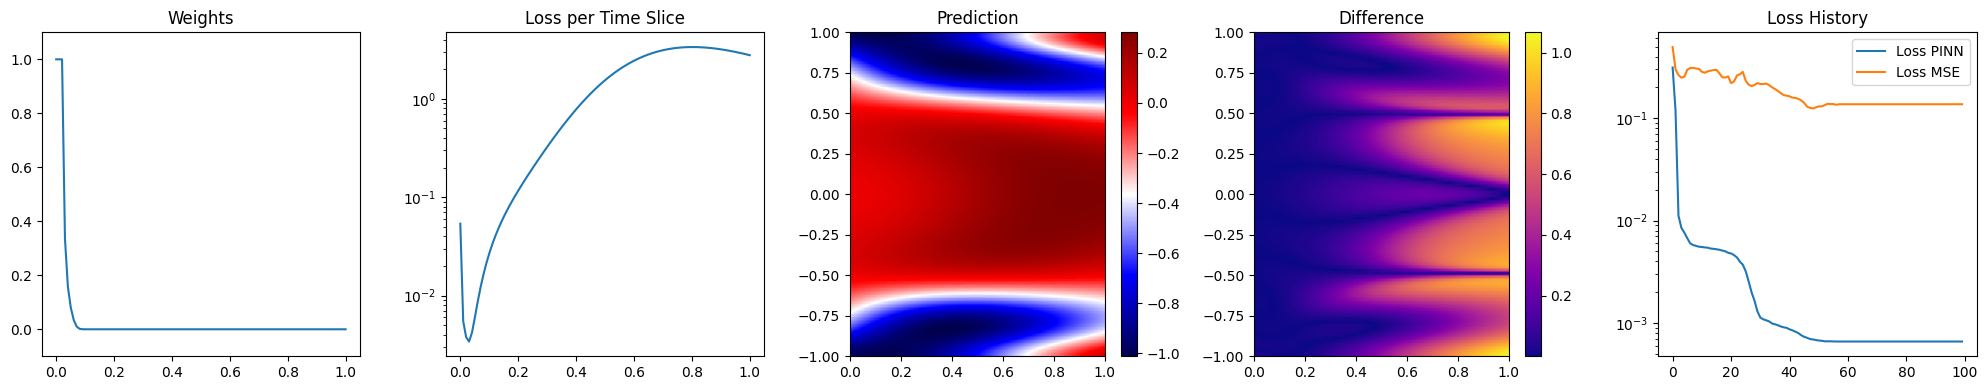

Epoch 99, Loss: 6.602142E-04 	 MSE_ref: 1.368234E-01 	 Duration: 0:00:04.731917
Going to next eps


In [8]:
if USE_CAUSALITY:
    temporal_weights = torch.ones(T_COLOC_POINTS, device=device)
    for eps in eps_array:
        for j in range(100):
            start = datetime.datetime.now()
            
            temporal_weights = compute_temporal_weights()
            opt.step(closure)

            loss_hist.append(loss_fnc().item())
            loss_MSE.append(compute_MSE_ref())

            plot_causality_training()
            plt.pause(0.01)

            if (torch.min(temporal_weights) > sigma):
                break
            
            print(f"Epoch {j}, Loss: {loss_fnc().item():2E} \t MSE_ref: {compute_MSE_ref():2E} \t Duration: {datetime.datetime.now() -start}")
        print(f"Going to next eps")

else:
    previous_loss = float('inf')
    for i in range(100):
        opt.step(closure)
        clear_output(wait=True)
        plt.imshow(model(input_domain).reshape(T_COLOC_POINTS, X_COLOC_POINTS).detach().cpu().T, cmap="seismic")
        plt.colorbar()
        plt.show()
        if abs(previous_loss - loss_fnc().item()) < 1e-10:
            break
        previous_loss = loss_fnc().item()
        
        loss_hist.append(loss_fnc().item())
        loss_MSE.append(compute_MSE_ref())
        print(f"Epoch {i}, Loss: {loss_fnc().item():2E} \t MSE_ref: {compute_MSE_ref():2E}", end="\r")

    print(f"Final Loss: {loss_fnc().item():.2E}  \t Layers: {N_LAYERS} \t Qubits: {N_WIRES} \t MSE_ref: {compute_MSE_ref()} \t Iterations: {i} ")


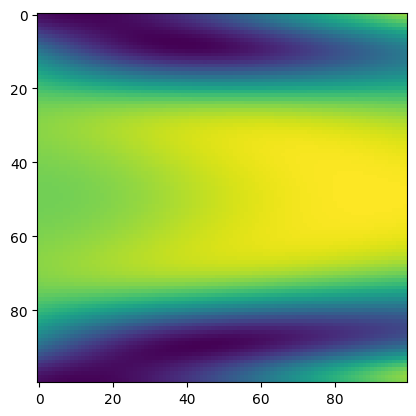

In [9]:
plt.imshow(model(input_domain).detach().cpu().numpy().reshape(T_COLOC_POINTS, X_COLOC_POINTS).T)

In [10]:
print("x y ref_solution model_fnn_4_qubits")
t_plot = torch.linspace(0.0, T_END, 40)
x_plot = torch.linspace(-1.0, 1.0, 50)
plot_domain = torch.tensor(list(product(t_plot, x_plot)), device=device)
u = model(plot_domain).detach().cpu().numpy()

reference_values_plot = reference_solution_fnc(plot_domain.detach().cpu())

for i in range(plot_domain.shape[0]):
    print(plot_domain[i,0].item(), plot_domain[i,1].item(), reference_values_plot[i].item(), u[i].item())

x y ref_solution model_fnn_4_qubits
0.0 -1.0 -1.0000000000000002 -0.9634155929088593
0.0 -0.9591836929321289 -0.9124599589916349 -0.9248113036155701
0.0 -0.918367326259613 -0.815794110367587 -0.8315770924091339
0.0 -0.8775510191917419 -0.7138057399551386 -0.7179824113845825
0.0 -0.8367347121238708 -0.6100422646736567 -0.6048370003700256
0.0 -0.795918345451355 -0.5077156660614153 -0.5006755888462067
0.0 -0.7551020383834839 -0.4096377193504024 -0.40636569261550903
0.0 -0.7142857313156128 -0.3181696896906925 -0.3199610412120819
0.0 -0.6734694242477417 -0.23518997637698685 -0.23996901512145996
0.0 -0.6326530575752258 -0.16207749372202584 -0.1666051745414734
0.0 -0.5918367505073547 -0.09971200647121685 -0.10151785612106323
0.0 -0.5510204434394836 -0.04848895119660677 -0.046821922063827515
0.0 -0.5102040767669678 -0.008349701865418847 -0.004119455814361572
0.0 -0.4693877696990967 0.021139455951791813 0.026092588901519775
0.0 -0.4285714328289032 0.04083957108120512 0.04454490542411804
0.0 -0.

/var/folders/mg/wnh4_z1j7_l6stml2x35_z340000gn/T/ipykernel_51209/4245990616.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[i] = u_interp([data[i, 0], data[i, 1]])
